## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
# setting the seed to align with project set up
random.seed(42)


a. Reading the dataset and taking a look at the top few rows:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. The number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match, as well as `old_page` and `control`.

In [6]:
df.query('landing_page == "new_page" and group != "treatment" or landing_page == "old_page" and group != "control"  ').shape[0]

3893

f. Checking missing values:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


No missing values

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. So I will create a new dataset and store all the values except for the unmatched rows.

In [8]:
df2 = df
not_matched= df2.loc[((df2['landing_page'] == "new_page") & (df2['group'] != "treatment")) | ( (df2['landing_page'] == "old_page") & (df2['group'] != "control") )].index
df2.drop(not_matched,inplace=True)

In [9]:
# Double Check all of the correct rows were removed 
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False]

,user_id,timestamp,group,landing_page,converted


In [10]:
#checking the total number of entries
df.shape[0]

290585

a.Checking how many unique **user_id**s are in **df2**

In [11]:
df2.user_id.nunique()

290584

b. Since the total number of entries differs from the number of unique users this leads us to the conclusion that there is one **user_id** repeated in **df2**.

In [12]:
# Locating the duplicated user and its info
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Removing **one** of the rows with a duplicate **user_id**, but keeping the dataframe as **df2**.

In [13]:
df2.drop(2893,inplace=True)

In [14]:
# only one entry with the same user_id
df[df['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0



e. What is the probability of an individual converting regardless of the page they receive?

In [15]:
conversion_rate = df2['converted'].mean()
conversion_rate

0.11959708724499628

f. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
control_conv_mean = df2[df2['group']=="control"].converted.mean()
control_conv_mean

0.1203863045004612

g. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
treatment_conv_mean = df2[df2['group']=="treatment"].converted.mean()
treatment_conv_mean

0.11880806551510564

h. What is the probability that an individual received the new page?

In [18]:
df2[df2['landing_page']=="new_page"].shape[0] / df2['landing_page'].shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**There is no sufficient evidence to conclude that the new treatment page leads to more conversions, rather the obtained results sugguest that there is approximately no difference between the two pages.**

<a id='ab_test'></a>
### Part II - A/B Test


`1.` I will assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. <br> **$p_{old}$** and **$p_{new}$**, are the converted rates for the old and new pages.

$$ H_0: p_{new} - p_{old} \leq 0  $$
$$ H_1: p_{new} - p_{old} > 0 $$

`2.`  Assuming under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, I will assume that they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br>

I will use a sample size for each page equal to the ones in **ab_data.csv**.
I will perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. The **conversion rate** for $p_{new}$ under the null:

In [19]:
p_new = conversion_rate
p_new

0.11959708724499628

b. The **conversion rate** for $p_{old}$ under the null: <br>

In [20]:
p_old = conversion_rate
p_old

0.11959708724499628

c. The number of individuals in the treatment group $n_{new}$:

In [21]:
n_new = df2[df2['group']=="treatment"].shape[0]
n_new

145310

d. The number of individuals in the control group $n_{old}$:

In [22]:
n_old = df2[df2['group']=="control"].shape[0]
n_old

145274

e. Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.

In [23]:
new_page_converted = np.random.choice([0,1], size=n_new,p=[1-p_new,p_new])

f. Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.

In [24]:
old_page_converted = np.random.choice([0,1],size=n_old,p=[1-p_old,p_old])

g. Finding $p_{new}$ - $p_{old}$ for my simulated values from part (e) and (f).

In [25]:
new_page_converted.mean() - old_page_converted.mean()

0.000940751072143392

h. Creating 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process I used in parts (a) through (g) above, and storing all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
p_diffs=[]

for i in range(10000):
    new_page_conv = np.random.choice([0,1], size=n_new,p=[1-p_new,p_new])
    old_page_conv = np.random.choice([0,1], size=n_old,p=[1-p_old,p_old])
    #appending
    p_diffs.append(new_page_conv.mean() - old_page_conv.mean())

i. Histogram of the **p_diffs**.

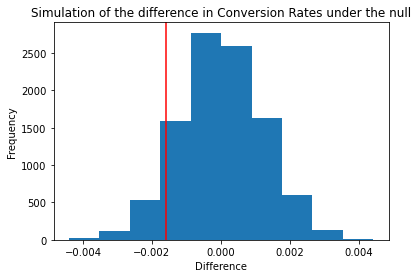

In [30]:
plt.hist(p_diffs);
plt.title('Simulation of the difference in Conversion Rates under the null');
plt.ylabel('Frequency');
plt.xlabel('Difference');
plt.axvline(actual_diff, color='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
# Acutal Difference 
actual_diff = treatment_conv_mean-control_conv_mean
# proportion of p_diffs that are greater than actual_diff
(np.array(p_diffs) > actual_diff).mean()

0.9104

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The computed value is the p-value, and since it is greater than 0.05 this suggests that we have evidence that our statistic was likely to come from the null hypothesis which states that the difference of the conversion rates for the new page and old page is less than or equal to 0**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = df2[df2['landing_page']=='old_page'].converted.sum()
convert_new = df2[df2['landing_page']=='new_page'].converted.sum()
n_old = df2[df2['landing_page']=='old_page'].shape[0]
n_new = df2[df2['landing_page']=='new_page'].shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [32]:

stat, pval = sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old])
stat, pval

(-1.3109241984234394, 0.18988337448195103)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The Z-score value tells us that we are below the mean by 1.31 standard deviations which suggests that the conversion rate for the new page is below the old page conversion rate, the p-value differs from the one obtained in part j because we assumed that p_new and p_old were the same, while it is not. but since it is greater than 0.05 it still suggests that we can not reject the null**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression, since it is a binary case that involves qualitative variables.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
df2['intercept'] = 1
df2[['a_page','ab_page']] = pd.get_dummies(df2['group'])
# dropping a_page 
df2.drop('a_page', 1,inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [34]:
logistic_model = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = logistic_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-08-22 00:34 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value associated with ab_page equals to 0.189 which is similar to the obtained value in Part II, logistic regression is two-tailed test while what we done in the previous part is one tailed test**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Adding other factors will let us explore other areas where it might affect the conversion rates of users, the disadvatage is if the factors are related to each other in other words there might be a multicollinearity between tha added variables**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [36]:
# having a look over countries.csv
countries = pd.read_csv('countries.csv')
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  290584 non-null  int64 
 1   country  290584 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [37]:
# joining dataframes
df3 = df2.join(countries.set_index('user_id'),on='user_id')
# getting the to see the unique values to determine how many columns to add
df3.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [38]:
# creating dummy variables for country column
df3[['CA','UK','US']]=pd.get_dummies(df3['country'])

In [39]:
logistic_model = sm.Logit(df3['converted'],df3[['intercept','CA','UK']])
results = logistic_model.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2021-08-22 00:34 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

**The P-Values are still greater than 0.05 which suggests us to stick with our null hypothesis.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [40]:
# Creating interactions between each country column and ab_page
df3['CA_Page']= df3['CA'] * df3['ab_page']
df3['UK_Page']= df3['UK'] * df3['ab_page']
# creating logistic regression model
logistic_model = sm.Logit(df3['converted'],df3[['intercept','CA','UK','CA_Page','UK_Page']])
results = logistic_model.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.9259
Date:               2021-08-22 00:34 BIC:              212835.8241
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           4                LL-Null:          -1.0639e+05
Df Residuals:       290579           LLR p-value:      0.27295    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0073    0.0371    -0.1963  0.8444  -0.0799   0.0654
UK            0.0045    0.0175     0.2572  0.7970  -0.0298   0.0389
CA_Page      -0.0674    0.0520    -1.2967  0.1947  -0.1694   0.0345
UK_Page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
==================================================================

"""

**Apparently the p-values associated with the variables are not statistically significant as it is greater than 0.05**


>**In conclusion, we do not have enough evidence to reject the null hypothesis, so sticking to our old page might be the best in terms of cost.**